In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, iirnotch
from io import StringIO

In [5]:
file_path1 = 'emg+dataset+in+lower+limb/SEMG_DB1/A_TXT/1Amar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

#Normalisation des données
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])
    data[col] = normalize_data(data[col])

data["FX"]=abs(data["FX"])

print(data.head())

         RF        BF        VM        ST   FX  Time
0  0.544182  0.645101  0.583190  0.561737  9.0     0
1  0.595353  0.597292  0.616203  0.620305  9.0     1
2  0.594741  0.592874  0.605869  0.612025  9.0     2
3  0.590076  0.614065  0.587361  0.624091  9.0     3
4  0.589965  0.657794  0.575495  0.631465  9.0     4


In [22]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks) - 1):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = max(0, peaks[i] - shift_amount)
    adjusted_peaks.append(adjusted_start)

# Vérification et correction des cycles manquants
new_adjusted_peaks = [adjusted_peaks[0]]
for i in range(1, len(adjusted_peaks)):
    if adjusted_peaks[i] - new_adjusted_peaks[-1] > 0.6 * mean_cycle_length:
        new_adjusted_peaks.append(adjusted_peaks[i])

adjusted_peaks = new_adjusted_peaks

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(adjusted_peaks)

Nombre de débuts de cycles ajustés : 7
[227, 1666, 3153, 6618, 8094, 9492, 10912]


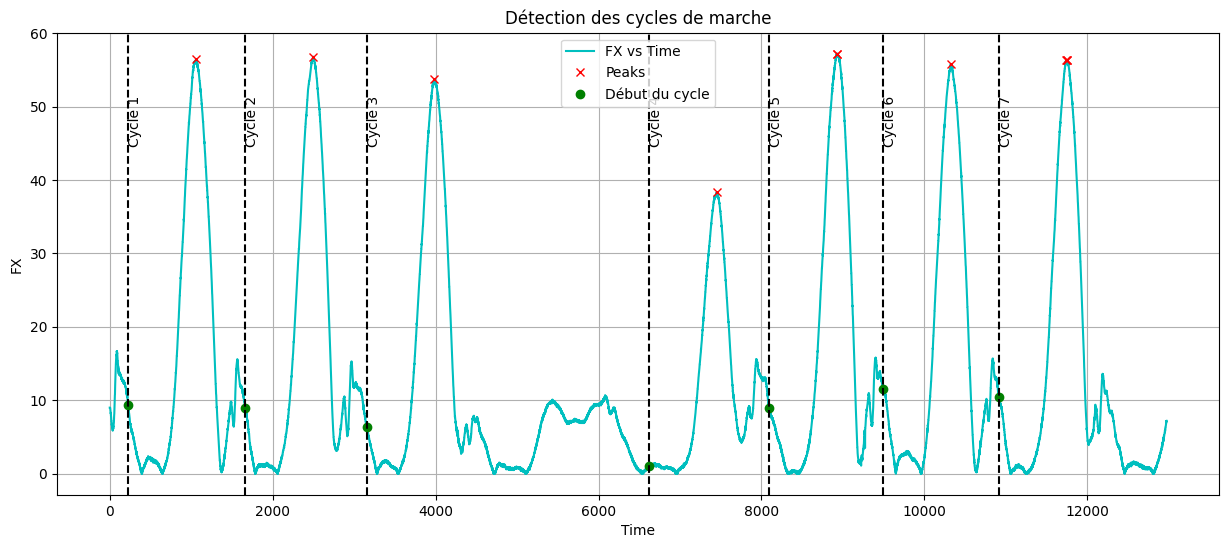

In [23]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()
